# Pathogen Detection Database

## Introduction
This notebook downloads the latest dataset from the [Pathogen Detection Database](https://www.ncbi.nlm.nih.gov/pathogens/isolates/#taxgroup_name:%22Salmonella%20enterica%22) and performs various data processing and cleaning steps.

---

1. **Load Data:**
- New columns added
  - Lat/Lon
  - Length
  - PFGE Primary Enzyme Pattern
  - PFGE Secondary Enzyme Pattern

2. **Data Processing:**
- Rename serovars:
  - I 4,[5],12:i:- to I4
  - Albany or Duesseldorf to Albany
- Rename columns name

3. **Data Cleaning:**
- Missing values:
  - Add missing FSIS/PNUSA ID to the "Strain" column if empty.
-  Check and delete duplicate values on the biosample ID column.
- Remove non-US isolates





In [ ]:
import pandas as pd
import os
import numpy as np
from datetime import date

# mount google drive
from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from google.colab import drive
drive.mount('/content/drive')
path = '/pathogen-detection/'
dfs = []

Mounted at /content/drive


SELECT computed_types.serotype
FROM `ncbi-pathogen-detect.pdbrowser.isolates`
WHERE computed_types.serotype in ('Give', "Infantis")
AND taxgroup_name LIKE 'Salmonella%'



# 1.   Load data



In [ ]:
project = 'salmonella-enterica-bigquery' # Project ID inserted based on the query results selected to explore
location = 'us-east1' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

# Running this code will display the query used to generate your previous job
# https://console.cloud.google.com/bigquery?project=salmonella-enterica-bigquery&ws=!1m5!1m4!1m3!1ssalmonella-enterica-bigquery!2sbquxjob_1ff1280_186f0f578da!3sus-east1
# https://www.ncbi.nlm.nih.gov/pathogens/isolates/#taxgroup_name:%22Salmonella%20enterica%22

query = """
SELECT isolate_identifiers, taxgroup_name, creation_date, computed_types.serotype, Run, strain,
      biosample_acc, target_acc, bioproject_acc, wgs_master_acc, serovar, collection_date, sra_release_date,
      geo_loc_name, lat_lon, IFSAC_category, host, host_disease, epi_type, isolation_source, source_type,
      collected_by, sra_center, Platform, LibraryLayout, asm_acc, asm_stats_length_bp, erd_group,  PFGE_PrimaryEnzyme_pattern,
      PFGE_SecondaryEnzyme_pattern, outbreak
FROM `ncbi-pathogen-detect.pdbrowser.isolates`
WHERE computed_types.serotype in ('Albany or Duesseldorf', 'Lubbock', 'Eko', 'Rissen', 'Meleagridis', 'Worthington', 'Infantis','Kiambu',
                                  'Ohio','London','Brandenburg', 'Give', 'Muenster', 'Johannesburg', 'Senftenberg', 'Cerro','Derby',
                                  'Mbandaka','Reading', 'Uganda','Berta', 'Dublin', 'Heidelberg', 'Schwarzengrund', 'Agona', 'Hadar',
                                  'Anatum', 'Thompson', 'Muenchen', 'Braenderup', 'Montevideo', 'Kentucky', 'Typhimurium', 'Newport',
                                  'Enteritidis', 'I 4,[5],12:i:-','Alachua')
AND taxgroup_name LIKE 'Salmonella%'
"""

job = client.query(query)
# job = client.get_job('bquxjob_30bba6d1_186ebc7f712') # Job ID inserted based on the query results selected to explore
print(job.query)


SELECT isolate_identifiers, taxgroup_name, creation_date, computed_types.serotype, Run, strain,
      biosample_acc, target_acc, bioproject_acc, wgs_master_acc, serovar, collection_date, sra_release_date,
      geo_loc_name, lat_lon, IFSAC_category, host, host_disease, epi_type, isolation_source, source_type,
      collected_by, sra_center, Platform, LibraryLayout, asm_acc, asm_stats_length_bp, erd_group,  PFGE_PrimaryEnzyme_pattern,
      PFGE_SecondaryEnzyme_pattern, outbreak
FROM `ncbi-pathogen-detect.pdbrowser.isolates`
WHERE computed_types.serotype in ('Albany or Duesseldorf', 'Lubbock', 'Eko', 'Rissen', 'Meleagridis', 'Worthington', 'Infantis','Kiambu',
                                  'Ohio','London','Brandenburg', 'Give', 'Muenster', 'Johannesburg', 'Senftenberg', 'Cerro','Derby',
                                  'Mbandaka','Reading', 'Uganda','Berta', 'Dublin', 'Heidelberg', 'Schwarzengrund', 'Agona', 'Hadar',
                                  'Anatum', 'Thompson', 'Muenche

In [ ]:
# job = client.get_job('bquxjob_30bba6d1_186ebc7f712') # Job ID inserted based on the query results
# Convert job data to a Pandas DataFrame
new_download = job.to_dataframe()
new_download

,isolate_identifiers,taxgroup_name,creation_date,serotype,Run,strain,biosample_acc,target_acc,bioproject_acc,wgs_master_acc,...,collected_by,sra_center,Platform,LibraryLayout,asm_acc,asm_stats_length_bp,erd_group,PFGE_PrimaryEnzyme_pattern,PFGE_SecondaryEnzyme_pattern,outbreak
0,"[41, DT160, ERS1456764]",Salmonella enterica,2017-10-29T20:39:12Z,Typhimurium,ERR1740440,DT160,SAMEA4557585,PDT000259121.2,PRJEB18077,None,...,None,MASSEY UNIVERSITY,ILLUMINA,PAIRED,None,4896590,PDS000014365.34,None,None,None
1,"[ERS1776915, L00531-15, Monophasic variant of ...",Salmonella enterica,2019-01-12T21:53:01Z,"I 4,[5],12:i:-",ERR2000333,Monophasic variant of S.Typhimurium,SAMEA104113022,PDT000435775.1,PRJEB18442,DAAMWS000000000.1,...,None,ANIMAL AND PLANT HEALTH AGENCY (APHA),ILLUMINA,PAIRED,GCA_010186365.1,4960798,PDS000176795.16,None,None,None
2,"[ERS1776984, Monophasic variant of S.Typhimuri...",Salmonella enterica,2019-01-12T21:53:15Z,"I 4,[5],12:i:-",ERR2000402,Monophasic variant of S.Typhimurium,SAMEA104113091,PDT000435844.1,PRJEB18442,DAAMZS000000000.1,...,None,ANIMAL AND PLANT HEALTH AGENCY (APHA),ILLUMINA,PAIRED,GCA_010188065.1,5030828,PDS000176793.11,None,None,None
3,"[6e03ae80-3988-11e7-8ae3-3c4a9275d6c8, ERS2021...",Salmonella enterica,2019-05-21T06:51:43Z,Typhimurium,ERR3060841,MA.0609R7589,SAMEA104403910,PDT000503874.1,PRJEB20997,None,...,None,WELLCOME SANGER INSTITUTE,ILLUMINA,PAIRED,None,4915083,PDS000065754.19,None,None,None
4,"[5ccfb0a0-3988-11e7-8ae3-3c4a9275d6c8, ERS1905...",Salmonella enterica,2019-01-23T23:57:40Z,Typhimurium,ERR2710949,MA.CS_NJ08.254,SAMEA104280230,PDT000449801.1,PRJEB20997,None,...,None,THE WELLCOME TRUST SANGER INSTITUTE,ILLUMINA,PAIRED,None,5009255,PDS000064996.5,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415605,"[CFSAN002064, SRS452293]",Salmonella enterica,2013-12-11T13:50:51Z,Heidelberg,None,CFSAN002064,SAMN01933202,PDT000019820.1,PRJNA191769,None,...,FDA,None,None,None,GCA_000505705.1,4821559,PDS000150683.16,JF6X01.0122,None,None
415606,"[648905 5-18, CFSAN000093, SRS348591]",Salmonella enterica,2012-07-19T14:51:00Z,Enteritidis,None,648905 5-18,SAMN01041137,PDT000010064.2,PRJNA62825,ALEZ00000000.1,...,FDA,None,None,None,GCA_000280415.1,4692738,PDS000030259.38,None,None,None
415607,"[ERS1973974, MS170264]",Salmonella enterica,2019-01-24T23:54:45Z,"I 4,[5],12:i:-",ERR2173654,None,SAMEA104348996,PDT000452081.1,PRJEB18998,DAJCFR000000000.1,...,None,UNIVERSITY HOSPITAL GALWAY,ILLUMINA,PAIRED,GCA_025077035.1,5096816,PDS000125104.65,None,None,None
415608,"[ERS1545071, MS160427]",Salmonella enterica,2019-01-24T23:53:38Z,"I 4,[5],12:i:-",ERR1818147,None,SAMEA80217418,PDT000451687.1,PRJEB18998,DAIWZQ000000000.1,...,None,UNIVERSITY HOSPITAL GALWAY,ILLUMINA,PAIRED,GCA_024837865.1,5237553,PDS000175554.1,None,None,None


01/08/24 406233 rows × 31 columns <br> 03/27/24 415610 rows × 31 columns

In [ ]:
new_download.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415610 entries, 0 to 415609
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   isolate_identifiers           415610 non-null  object
 1   taxgroup_name                 415610 non-null  object
 2   creation_date                 415610 non-null  object
 3   serotype                      415610 non-null  object
 4   Run                           392879 non-null  object
 5   strain                        388304 non-null  object
 6   biosample_acc                 415610 non-null  object
 7   target_acc                    415610 non-null  object
 8   bioproject_acc                415610 non-null  object
 9   wgs_master_acc                356020 non-null  object
 10  serovar                       211475 non-null  object
 11  collection_date               251329 non-null  object
 12  sra_release_date              392879 non-null  object
 13 

In [ ]:
# count the number of rows in the original download
original_download=len(new_download.index)
original_download

415610

#1. Data Processing

In [ ]:
# Rename column name
column_mapping = {
    'isolate_identifiers': 'Isolate identifiers',
    'taxgroup_name': 'Organism group',
    'creation_date': 'Create date',
    'Run': 'Run',
    'strain': 'Strain',
    'biosample_acc': 'BioSample',
    'target_acc': 'Isolate',
    'bioproject_acc': 'BioProject',
    'wgs_master_acc': 'WGS accession',
    'Serovar': 'Serovar',
    'serotype': 'Computed types',
    'collection_date': 'Collection date',
    'collected_by': 'Collected by',
    'geo_loc_name': 'Location',
    'lat_lon': 'Lat/Lon',
    'IFSAC_category': 'IFSAC category',
    'host': 'Host',
    'host_disease': 'Host disease',
    'epi_type': 'Isolation type',
    'isolation_source': 'Isolation source',
    'source_type': 'Source type',
    'sra_center': 'SRA Center',
    'sra_release_date': 'SRA release date',
    'Platform':'Platform',
    'LibraryLayout':'Library layout',
    'asm_acc':'Assembly',
    'asm_stats_length_bp':'Length',
    'erd_group':'SNP cluster',
    'PFGE_PrimaryEnzyme_pattern':'PFGE primary enzyme pattern',
    'PFGE_SecondaryEnzyme_pattern':'PFGE secondary enzyme pattern',
}

new_download.rename(columns=column_mapping, inplace=True)
new_download

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak
0,"[41, DT160, ERS1456764]",Salmonella enterica,2017-10-29T20:39:12Z,Typhimurium,ERR1740440,DT160,SAMEA4557585,PDT000259121.2,PRJEB18077,None,...,None,MASSEY UNIVERSITY,ILLUMINA,PAIRED,None,4896590,PDS000014365.34,None,None,None
1,"[ERS1776915, L00531-15, Monophasic variant of ...",Salmonella enterica,2019-01-12T21:53:01Z,"I 4,[5],12:i:-",ERR2000333,Monophasic variant of S.Typhimurium,SAMEA104113022,PDT000435775.1,PRJEB18442,DAAMWS000000000.1,...,None,ANIMAL AND PLANT HEALTH AGENCY (APHA),ILLUMINA,PAIRED,GCA_010186365.1,4960798,PDS000176795.16,None,None,None
2,"[ERS1776984, Monophasic variant of S.Typhimuri...",Salmonella enterica,2019-01-12T21:53:15Z,"I 4,[5],12:i:-",ERR2000402,Monophasic variant of S.Typhimurium,SAMEA104113091,PDT000435844.1,PRJEB18442,DAAMZS000000000.1,...,None,ANIMAL AND PLANT HEALTH AGENCY (APHA),ILLUMINA,PAIRED,GCA_010188065.1,5030828,PDS000176793.11,None,None,None
3,"[6e03ae80-3988-11e7-8ae3-3c4a9275d6c8, ERS2021...",Salmonella enterica,2019-05-21T06:51:43Z,Typhimurium,ERR3060841,MA.0609R7589,SAMEA104403910,PDT000503874.1,PRJEB20997,None,...,None,WELLCOME SANGER INSTITUTE,ILLUMINA,PAIRED,None,4915083,PDS000065754.19,None,None,None
4,"[5ccfb0a0-3988-11e7-8ae3-3c4a9275d6c8, ERS1905...",Salmonella enterica,2019-01-23T23:57:40Z,Typhimurium,ERR2710949,MA.CS_NJ08.254,SAMEA104280230,PDT000449801.1,PRJEB20997,None,...,None,THE WELLCOME TRUST SANGER INSTITUTE,ILLUMINA,PAIRED,None,5009255,PDS000064996.5,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415605,"[CFSAN002064, SRS452293]",Salmonella enterica,2013-12-11T13:50:51Z,Heidelberg,None,CFSAN002064,SAMN01933202,PDT000019820.1,PRJNA191769,None,...,FDA,None,None,None,GCA_000505705.1,4821559,PDS000150683.16,JF6X01.0122,None,None
415606,"[648905 5-18, CFSAN000093, SRS348591]",Salmonella enterica,2012-07-19T14:51:00Z,Enteritidis,None,648905 5-18,SAMN01041137,PDT000010064.2,PRJNA62825,ALEZ00000000.1,...,FDA,None,None,None,GCA_000280415.1,4692738,PDS000030259.38,None,None,None
415607,"[ERS1973974, MS170264]",Salmonella enterica,2019-01-24T23:54:45Z,"I 4,[5],12:i:-",ERR2173654,None,SAMEA104348996,PDT000452081.1,PRJEB18998,DAJCFR000000000.1,...,None,UNIVERSITY HOSPITAL GALWAY,ILLUMINA,PAIRED,GCA_025077035.1,5096816,PDS000125104.65,None,None,None
415608,"[ERS1545071, MS160427]",Salmonella enterica,2019-01-24T23:53:38Z,"I 4,[5],12:i:-",ERR1818147,None,SAMEA80217418,PDT000451687.1,PRJEB18998,DAIWZQ000000000.1,...,None,UNIVERSITY HOSPITAL GALWAY,ILLUMINA,PAIRED,GCA_024837865.1,5237553,PDS000175554.1,None,None,None


In [ ]:
# note: 'isolate_identifiers' is a list column
# Select rows only if 'PNUS' or 'FSIS' and create a new dataframe new_runs
new_runs = new_download[new_download['Isolate identifiers'].apply(lambda x: any(val.startswith(('PNUS', 'FSIS')) for val in x if pd.notna(val)))]

In [ ]:
# Select rows that only contain "ILLUMINA" in the "Platform" column and "Paired" in the "Library Layout" column
new_runs = new_runs[(new_runs['Platform'] == 'ILLUMINA') & (new_runs['Library layout'] == 'PAIRED')]

In [ ]:
new_runs['Library layout'].value_counts()

PAIRED    235268
Name: Library layout, dtype: int64

In [ ]:
new_runs

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak
365,"[M-22-1997-3, PNUSAS321481, SRS16111796]",Salmonella enterica,2022-12-13T17:52:49Z,Kentucky,SRR22707000,PNUSAS321481,SAMN32189689,PDT001525112.1,PRJNA215333,ABJUHG000000000.1,...,None,PULSENET,ILLUMINA,PAIRED,GCA_026883545.1,4963944,PDS000038055.146,None,None,None
366,"[CNSV-T20-MA11-10-RV-A, PNUSAS109536, SRS8989987]",Salmonella enterica,2021-05-15T22:47:09Z,Typhimurium,SRR14554314,PNUSAS109536,SAMN19222176,PDT001035719.1,PRJNA215333,ABAMBV000000000.1,...,None,PULSENET,ILLUMINA,PAIRED,GCA_018386365.1,4860164,PDS000026746.157,None,None,None
374,"[PNUSAS060859, SRS4042587]",Salmonella enterica,2018-11-15T00:51:01Z,Thompson,SRR8188949,PNUSAS060859,SAMN10424536,PDT000407373.1,PRJNA230403,AADJZC000000000.1,...,CDC,EDLB-CDC,ILLUMINA,PAIRED,GCA_005629375.1,4685300,PDS000032705.1128,None,None,None
375,"[PNUSAS178005, SRS7616966]",Salmonella enterica,2020-10-29T21:25:59Z,Mbandaka,SRR12935212,PNUSAS178005,SAMN16593625,PDT000872517.1,PRJNA230403,AAWWKT000000000.1,...,None,PULSENET,ILLUMINA,PAIRED,GCA_015168415.1,5060653,PDS000064917.29,None,None,None
376,"[PNUSAS154476, SRS7614468]",Salmonella enterica,2020-10-29T16:27:21Z,Typhimurium,SRR12931253,PNUSAS154476,SAMN16589032,PDT000871757.1,PRJNA230403,AAWVWG000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_015128525.1,4739842,PDS000114986.1,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415560,"[FSIS12212157, SRS13333074]",Salmonella enterica,2022-06-08T18:37:44Z,Schwarzengrund,SRR19581589,FSIS12212157,SAMN28922351,PDT001325161.1,PRJNA242847,ABGMRG000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_023694485.1,4729504,PDS000027514.374,None,None,None
415561,"[FSIS1608497, SRS1813067]",Salmonella enterica,2016-11-22T15:17:08Z,Schwarzengrund,SRR5043947,FSIS1608497,SAMN06046071,PDT000162520.2,PRJNA242847,AALXBR000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_009036365.1,4722495,PDS000027514.374,None,None,None
415562,"[FSIS11810534, SRS3430162]",Salmonella enterica,2018-06-19T01:03:14Z,Schwarzengrund,SRR7358417,FSIS11810534,SAMN09444117,PDT000332045.1,PRJNA242847,AAKLLK000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_008447785.1,4692211,PDS000027514.374,None,None,None
415563,"[FSIS11704778, SRS2605810]",Salmonella enterica,2017-10-18T18:38:18Z,Schwarzengrund,SRR6187465,FSIS11704778,SAMN07809366,PDT000253393.2,PRJNA242847,AAMUWM000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_009516955.1,4571700,PDS000027525.105,None,None,None


In [ ]:
# Rename "I 4,[5],12:i:-" to I4 and "Albany or Duesseldorf" to Albany
new_runs.loc[:,'Computed types'] = new_runs['Computed types'].replace({
     "I 4,[5],12:i:-" : "I4",
     "Albany or Duesseldorf" : "Albany"
})

In [ ]:
# counts per serovars
new_runs['Computed types'].value_counts()

Enteritidis       53767
Newport           33159
Typhimurium       30906
Infantis          19761
I4                14914
Kentucky           9249
Montevideo         8128
Braenderup         7787
Muenchen           7331
Thompson           6432
Anatum             5238
Agona              3458
Hadar              3222
Schwarzengrund     2900
Dublin             2826
Heidelberg         2599
Berta              2508
Uganda             2072
Mbandaka           2025
Reading            1798
Derby              1716
Senftenberg        1590
Cerro              1581
Johannesburg       1452
Muenster           1312
Brandenburg        1294
Give               1258
London              991
Ohio                815
Kiambu              578
Worthington         530
Rissen              451
Meleagridis         449
Eko                 438
Alachua             336
Albany              252
Lubbock             145
Name: Computed types, dtype: int64

In [ ]:
# Total number of dropped rows

new_rows = len(new_runs.index)
num_dropped_rows = original_download - new_rows
print(f"Total of rows deleted from original download after data processing: {num_dropped_rows}")
print(f"Total of new rows: {new_rows}")


Total of rows deleted from original download after data processing: 180342
Total of new rows: 235268


# 2. Data Cleaning

Read old dataset and remove existing runs from new dataset

In [ ]:
old_runs = pd.read_csv("/pathogen-detection/Metadata_OriginalDownload/pdd_dataset.csv")
old_runs


<ipython-input-14-0a4f68098b7a>:1: DtypeWarning: Columns (14,20,29) have mixed types. Specify dtype option on import or set low_memory=False.
  old_runs = pd.read_csv("/content/drive/MyDrive/pathogen-detection/Metadata_OriginalDownload/pdd_dataset.csv")


,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak
0,['PNUSAS346064' 'SRS17513600'],Salmonella enterica,2023-05-02T22:41:53Z,Enteritidis,SRR24392398,PNUSAS346064,SAMN34534445,PDT001717179.1,PRJNA230403,ABOZZD000000000.1,...,NaN,PULSENET,ILLUMINA,PAIRED,GCA_033759015.1,4775752.0,PDS000004754.78,NaN,NaN,NaN
1,['PNUSAS385620' 'SALM23-0874' 'SRS18966740'],Salmonella enterica,2023-09-25T20:56:31Z,Enteritidis,SRR26163173,PNUSAS385620,SAMN37529829,PDT001899965.1,PRJNA230403,NaN,...,SC,PULSENET,ILLUMINA,PAIRED,NaN,4812815.0,PDS000065765.219,NaN,NaN,NaN
2,['PNUSAS370902' 'SRS18550374'],Salmonella enterica,2023-08-08T22:47:37Z,Enteritidis,SRR25572917,PNUSAS370902,SAMN36892650,PDT001845585.1,PRJNA230403,ABMUNM000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_031835555.1,4937321.0,PDS000026865.601,NaN,NaN,NaN
3,['PNUSAS371179' 'SRS18572206'],Salmonella enterica,2023-08-10T19:50:43Z,Enteritidis,SRR25598432,PNUSAS371179,SAMN36932330,PDT001847774.1,PRJNA230403,ABMSCT000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_031727315.1,4948373.0,PDS000026865.601,NaN,NaN,NaN
4,['PNUSAS398984' 'SRS19437075'],Salmonella enterica,2023-11-07T19:14:17Z,Enteritidis,SRR26700616,PNUSAS398984,SAMN38143644,PDT001973757.1,PRJNA230403,ABOQXD000000000.1,...,NaN,PULSENET,ILLUMINA,PAIRED,GCA_033431675.1,4720062.0,PDS000004754.78,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229051,['FSIS12139650' 'SRS8959343'],Salmonella enterica,2021-05-13T22:29:27Z,I4,SRR14518526,FSIS12139650,SAMN19110620,PDT001025678.1,PRJNA242847,ABALUW000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_018356585.1,4983173.0,PDS000118515.1,NaN,NaN,NaN
229052,['FSIS22132305' 'SRS9662310'],Salmonella enterica,2021-08-07T13:27:48Z,I4,SRR15323829,FSIS22132305,SAMN20527159,PDT001101591.1,PRJNA242847,ABBVYX000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_019564135.1,5022127.0,PDS000125119.5,NaN,NaN,NaN
229053,['CFSAN074998' 'FSIS11705258' 'SRS2895275'],Salmonella enterica,2018-01-30T17:50:29Z,I4,SRR6650942,FSIS11705258,SAMN08386987,PDT000282868.2,PRJNA242847,AAPXJU000000000.1,...,USDA-FSIS,CFSAN,ILLUMINA,PAIRED,GCA_011396535.1,4855863.0,PDS000026786.15,NaN,NaN,NaN
229054,['FSIS12035105' 'SRS7620884'],Salmonella enterica,2020-10-30T06:27:38Z,I4,SRR12949930,FSIS12035105,SAMN16598140,PDT000872918.1,PRJNA292666,NaN,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,NaN,4950571.0,PDS000026786.15,NaN,NaN,NaN


In [ ]:
# find and remove row that already exist from the old dataset
runs_to_remove = new_runs[new_runs['Run'].isin(old_runs['Run'])].index
final_df = new_runs.drop(runs_to_remove)

final_df

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak
409,"[PNUSAS422045, SRS20544877]",Salmonella enterica,2024-02-23T18:26:43Z,Muenchen,SRR28066038,PNUSAS422045,SAMN40077465,PDT002085031.1,PRJNA230403,ABQJLT000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_036854955.1,4876851,PDS000027403.222,None,None,None
410,"[PNUSAS426183, SRS20776108]",Salmonella enterica,2024-03-18T17:20:59Z,Enteritidis,SRR28372877,PNUSAS426183,SAMN40526689,PDT002115528.1,PRJNA230403,None,...,CDC,PULSENET,ILLUMINA,PAIRED,None,4766022,PDS000083226.623,None,None,None
542,"[PNUSAS417284, SRS20280592]",Salmonella enterica,2024-01-30T00:00:39Z,Enteritidis,SRR27760813,PNUSAS417284,SAMN39655628,PDT002067168.1,PRJNA230403,ABQFAO000000000.1,...,None,PULSENET,ILLUMINA,PAIRED,GCA_036483255.1,4740845,PDS000121797.33,None,None,None
557,"[PNUSAS422830, SRS20593890]",Salmonella enterica,2024-02-28T00:59:30Z,Anatum,SRR28123705,PNUSAS422830,SAMN40176125,PDT002089308.1,PRJNA230403,None,...,CDC,PULSENET,ILLUMINA,PAIRED,None,4729502,PDS000158028.3,None,None,None
574,"[PNUSAS418354, SRS20348760]",Salmonella enterica,2024-02-02T00:09:17Z,Typhimurium,SRR27833486,PNUSAS418354,SAMN39726635,PDT002070482.1,PRJNA230403,ABQDSO000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_036460925.1,5016425,PDS000026757.253,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414382,"[FSIS12427882, SRS20243951]",Salmonella enterica,2024-01-25T00:56:01Z,Kentucky,SRR27716249,FSIS12427882,SAMN39598450,PDT002063625.1,PRJNA242847,ABPZUE000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_036127885.1,5124746,PDS000174070.5,None,None,None
414395,"[FSIS22415484, SRS20547954]",Salmonella enterica,2024-02-23T22:04:40Z,Kentucky,SRR28069521,FSIS22415484,SAMN40079473,PDT002085288.1,PRJNA242847,ABQJNO000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_036856195.1,4857288,PDS000004095.339,None,None,None
414423,"[FSIS12428479, SRS20633603]",Salmonella enterica,2024-03-01T22:09:41Z,Kentucky,SRR28197574,FSIS12428479,SAMN40217694,PDT002094360.1,PRJNA292666,ABQMQG000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_036943905.1,4942742,PDS000004095.339,None,None,None
414476,"[FSIS12427916, SRS20361245]",Salmonella enterica,2024-02-03T00:17:47Z,Muenchen,SRR27847778,FSIS12427916,SAMN39750376,PDT002071299.1,PRJNA242847,ABQDBL000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_036439335.1,5037926,None,None,None,None


Dealling with missing values on strain column


In [ ]:
# Get values starting with 'PNUS' or 'FSIS' and update the 'Stain' column only when it doesn't start with 'PNUS' or 'FSIS'
final_df['Strain'] = final_df.apply(lambda row: next((value for value in row['Isolate identifiers'] if value.startswith('PNUS') or value.startswith('FSIS')), row['Strain']), axis=1)


Remove Isolates that are non-US

In [ ]:
final_df['Location'] = final_df['Location'].astype(str)

# Filter rows that do not start with 'USA'
notUs = final_df[~final_df['Location'].str.startswith('USA')]

notUs['Location'].value_counts()

None      1794
Canada       3
Syria        2
Name: Location, dtype: int64

In [ ]:
notUs = final_df[(final_df['Location'] == 'Syria') | (final_df['Location'] == 'Canada')].index
final_df.drop(notUs, inplace=True)

final_df['Location'].value_counts()

USA       3167
None      1794
USA:WI     162
USA:TX     107
USA:GA     102
USA:CA     100
USA:SC      92
USA:AR      53
USA:NC      50
USA:NY      49
USA:AL      46
USA:PA      46
USA:VT      41
USA:IL      32
USA:VA      31
USA:MD      27
USA:MI      27
USA:TN      25
USA:WA      22
USA:MS      21
USA:ID      21
USA:KY      20
USA:NJ      20
USA:MO      19
USA:MN      18
USA:NE      18
USA:IA      15
USA:OH      14
USA:LA      13
USA:ME      12
USA:IN      12
USA:MA      12
USA:NM      10
USA:KS      10
USA:AZ       8
USA:PR       8
USA:OK       8
USA:DE       7
USA:FL       7
USA:CO       6
USA:RI       6
USA:SD       5
USA:CT       4
USA:UT       3
USA:WV       2
USA:MT       1
Name: Location, dtype: int64

In [ ]:
final_df['Computed types'].value_counts()
# new_runs['Computed types'].value_counts()

Enteritidis       2020
Newport            663
Typhimurium        635
Infantis           483
I4                 427
Braenderup         278
Kentucky           229
Montevideo         189
Muenchen           149
Agona              133
Thompson           126
Anatum             119
Dublin             104
Hadar               91
Uganda              70
Schwarzengrund      58
Berta               48
Senftenberg         47
Mbandaka            42
Give                39
Brandenburg         35
Cerro               32
Muenster            30
Derby               30
Johannesburg        24
Reading             22
Heidelberg          21
Rissen              20
London              18
Kiambu              18
Alachua             15
Worthington         14
Eko                 11
Ohio                10
Meleagridis          9
Albany               9
Lubbock              5
Name: Computed types, dtype: int64

In [ ]:
duplicated_biosample = final_df[final_df['BioSample'].duplicated(keep=False)]
duplicated_biosample

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak


In [ ]:
duplicated_strain = final_df[final_df['Strain'].duplicated(keep=False)]
duplicated_strain

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak


In [ ]:
duplicated_strain = final_df[final_df['Run'].duplicated(keep=False)]
duplicated_strain

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak


In [ ]:
final_df

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak
409,"[PNUSAS422045, SRS20544877]",Salmonella enterica,2024-02-23T18:26:43Z,Muenchen,SRR28066038,PNUSAS422045,SAMN40077465,PDT002085031.1,PRJNA230403,ABQJLT000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_036854955.1,4876851,PDS000027403.222,None,None,None
410,"[PNUSAS426183, SRS20776108]",Salmonella enterica,2024-03-18T17:20:59Z,Enteritidis,SRR28372877,PNUSAS426183,SAMN40526689,PDT002115528.1,PRJNA230403,None,...,CDC,PULSENET,ILLUMINA,PAIRED,None,4766022,PDS000083226.623,None,None,None
542,"[PNUSAS417284, SRS20280592]",Salmonella enterica,2024-01-30T00:00:39Z,Enteritidis,SRR27760813,PNUSAS417284,SAMN39655628,PDT002067168.1,PRJNA230403,ABQFAO000000000.1,...,None,PULSENET,ILLUMINA,PAIRED,GCA_036483255.1,4740845,PDS000121797.33,None,None,None
557,"[PNUSAS422830, SRS20593890]",Salmonella enterica,2024-02-28T00:59:30Z,Anatum,SRR28123705,PNUSAS422830,SAMN40176125,PDT002089308.1,PRJNA230403,None,...,CDC,PULSENET,ILLUMINA,PAIRED,None,4729502,PDS000158028.3,None,None,None
574,"[PNUSAS418354, SRS20348760]",Salmonella enterica,2024-02-02T00:09:17Z,Typhimurium,SRR27833486,PNUSAS418354,SAMN39726635,PDT002070482.1,PRJNA230403,ABQDSO000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_036460925.1,5016425,PDS000026757.253,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414382,"[FSIS12427882, SRS20243951]",Salmonella enterica,2024-01-25T00:56:01Z,Kentucky,SRR27716249,FSIS12427882,SAMN39598450,PDT002063625.1,PRJNA242847,ABPZUE000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_036127885.1,5124746,PDS000174070.5,None,None,None
414395,"[FSIS22415484, SRS20547954]",Salmonella enterica,2024-02-23T22:04:40Z,Kentucky,SRR28069521,FSIS22415484,SAMN40079473,PDT002085288.1,PRJNA242847,ABQJNO000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_036856195.1,4857288,PDS000004095.339,None,None,None
414423,"[FSIS12428479, SRS20633603]",Salmonella enterica,2024-03-01T22:09:41Z,Kentucky,SRR28197574,FSIS12428479,SAMN40217694,PDT002094360.1,PRJNA292666,ABQMQG000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_036943905.1,4942742,PDS000004095.339,None,None,None
414476,"[FSIS12427916, SRS20361245]",Salmonella enterica,2024-02-03T00:17:47Z,Muenchen,SRR27847778,FSIS12427916,SAMN39750376,PDT002071299.1,PRJNA242847,ABQDBL000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_036439335.1,5037926,None,None,None,None


01/08/24 36317 rows × 31 columns <br> After final cleaning <br> 01/08/24 36312 rows × 31 columns

## 3. Save new runs

In [ ]:
final_df.to_csv("/pathogen-detection/Metadata_OriginalDownload/pdd_27Mar24.csv", index=False, encoding='utf-8')

In [ ]:
read_final_df = pd.read_csv("/pathogen-detection/Metadata_OriginalDownload/pdd_27Mar24.csv")

# Updated pdd-dataset

In [ ]:
old_dataset = pd.read_csv("/pathogen-detection/Metadata_OriginalDownload/pdd_dataset.csv")

<ipython-input-25-f30278730ee0>:1: DtypeWarning: Columns (14,20,29) have mixed types. Specify dtype option on import or set low_memory=False.
  old_dataset = pd.read_csv("/content/drive/MyDrive/pathogen-detection/Metadata_OriginalDownload/pdd_dataset.csv")


In [ ]:
old_dataset

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak
0,['PNUSAS346064' 'SRS17513600'],Salmonella enterica,2023-05-02T22:41:53Z,Enteritidis,SRR24392398,PNUSAS346064,SAMN34534445,PDT001717179.1,PRJNA230403,ABOZZD000000000.1,...,NaN,PULSENET,ILLUMINA,PAIRED,GCA_033759015.1,4775752.0,PDS000004754.78,NaN,NaN,NaN
1,['PNUSAS385620' 'SALM23-0874' 'SRS18966740'],Salmonella enterica,2023-09-25T20:56:31Z,Enteritidis,SRR26163173,PNUSAS385620,SAMN37529829,PDT001899965.1,PRJNA230403,NaN,...,SC,PULSENET,ILLUMINA,PAIRED,NaN,4812815.0,PDS000065765.219,NaN,NaN,NaN
2,['PNUSAS370902' 'SRS18550374'],Salmonella enterica,2023-08-08T22:47:37Z,Enteritidis,SRR25572917,PNUSAS370902,SAMN36892650,PDT001845585.1,PRJNA230403,ABMUNM000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_031835555.1,4937321.0,PDS000026865.601,NaN,NaN,NaN
3,['PNUSAS371179' 'SRS18572206'],Salmonella enterica,2023-08-10T19:50:43Z,Enteritidis,SRR25598432,PNUSAS371179,SAMN36932330,PDT001847774.1,PRJNA230403,ABMSCT000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_031727315.1,4948373.0,PDS000026865.601,NaN,NaN,NaN
4,['PNUSAS398984' 'SRS19437075'],Salmonella enterica,2023-11-07T19:14:17Z,Enteritidis,SRR26700616,PNUSAS398984,SAMN38143644,PDT001973757.1,PRJNA230403,ABOQXD000000000.1,...,NaN,PULSENET,ILLUMINA,PAIRED,GCA_033431675.1,4720062.0,PDS000004754.78,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229051,['FSIS12139650' 'SRS8959343'],Salmonella enterica,2021-05-13T22:29:27Z,I4,SRR14518526,FSIS12139650,SAMN19110620,PDT001025678.1,PRJNA242847,ABALUW000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_018356585.1,4983173.0,PDS000118515.1,NaN,NaN,NaN
229052,['FSIS22132305' 'SRS9662310'],Salmonella enterica,2021-08-07T13:27:48Z,I4,SRR15323829,FSIS22132305,SAMN20527159,PDT001101591.1,PRJNA242847,ABBVYX000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_019564135.1,5022127.0,PDS000125119.5,NaN,NaN,NaN
229053,['CFSAN074998' 'FSIS11705258' 'SRS2895275'],Salmonella enterica,2018-01-30T17:50:29Z,I4,SRR6650942,FSIS11705258,SAMN08386987,PDT000282868.2,PRJNA242847,AAPXJU000000000.1,...,USDA-FSIS,CFSAN,ILLUMINA,PAIRED,GCA_011396535.1,4855863.0,PDS000026786.15,NaN,NaN,NaN
229054,['FSIS12035105' 'SRS7620884'],Salmonella enterica,2020-10-30T06:27:38Z,I4,SRR12949930,FSIS12035105,SAMN16598140,PDT000872918.1,PRJNA292666,NaN,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,NaN,4950571.0,PDS000026786.15,NaN,NaN,NaN


In [ ]:
combined_datasets = pd.concat([final_df, old_dataset], ignore_index=True)
combined_datasets

,Isolate identifiers,Organism group,Create date,Computed types,Run,Strain,BioSample,Isolate,BioProject,WGS accession,...,Collected by,SRA Center,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,outbreak
0,"[PNUSAS422045, SRS20544877]",Salmonella enterica,2024-02-23T18:26:43Z,Muenchen,SRR28066038,PNUSAS422045,SAMN40077465,PDT002085031.1,PRJNA230403,ABQJLT000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_036854955.1,4876851.0,PDS000027403.222,None,None,None
1,"[PNUSAS426183, SRS20776108]",Salmonella enterica,2024-03-18T17:20:59Z,Enteritidis,SRR28372877,PNUSAS426183,SAMN40526689,PDT002115528.1,PRJNA230403,None,...,CDC,PULSENET,ILLUMINA,PAIRED,None,4766022.0,PDS000083226.623,None,None,None
2,"[PNUSAS417284, SRS20280592]",Salmonella enterica,2024-01-30T00:00:39Z,Enteritidis,SRR27760813,PNUSAS417284,SAMN39655628,PDT002067168.1,PRJNA230403,ABQFAO000000000.1,...,None,PULSENET,ILLUMINA,PAIRED,GCA_036483255.1,4740845.0,PDS000121797.33,None,None,None
3,"[PNUSAS422830, SRS20593890]",Salmonella enterica,2024-02-28T00:59:30Z,Anatum,SRR28123705,PNUSAS422830,SAMN40176125,PDT002089308.1,PRJNA230403,None,...,CDC,PULSENET,ILLUMINA,PAIRED,None,4729502.0,PDS000158028.3,None,None,None
4,"[PNUSAS418354, SRS20348760]",Salmonella enterica,2024-02-02T00:09:17Z,Typhimurium,SRR27833486,PNUSAS418354,SAMN39726635,PDT002070482.1,PRJNA230403,ABQDSO000000000.1,...,CDC,PULSENET,ILLUMINA,PAIRED,GCA_036460925.1,5016425.0,PDS000026757.253,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235324,['FSIS12139650' 'SRS8959343'],Salmonella enterica,2021-05-13T22:29:27Z,I4,SRR14518526,FSIS12139650,SAMN19110620,PDT001025678.1,PRJNA242847,ABALUW000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_018356585.1,4983173.0,PDS000118515.1,NaN,NaN,NaN
235325,['FSIS22132305' 'SRS9662310'],Salmonella enterica,2021-08-07T13:27:48Z,I4,SRR15323829,FSIS22132305,SAMN20527159,PDT001101591.1,PRJNA242847,ABBVYX000000000.1,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,GCA_019564135.1,5022127.0,PDS000125119.5,NaN,NaN,NaN
235326,['CFSAN074998' 'FSIS11705258' 'SRS2895275'],Salmonella enterica,2018-01-30T17:50:29Z,I4,SRR6650942,FSIS11705258,SAMN08386987,PDT000282868.2,PRJNA242847,AAPXJU000000000.1,...,USDA-FSIS,CFSAN,ILLUMINA,PAIRED,GCA_011396535.1,4855863.0,PDS000026786.15,NaN,NaN,NaN
235327,['FSIS12035105' 'SRS7620884'],Salmonella enterica,2020-10-30T06:27:38Z,I4,SRR12949930,FSIS12035105,SAMN16598140,PDT000872918.1,PRJNA292666,NaN,...,USDA-FSIS,USDA-FSIS,ILLUMINA,PAIRED,NaN,4950571.0,PDS000026786.15,NaN,NaN,NaN


In [ ]:
combined_datasets.to_csv("/pathogen-detection/Metadata_OriginalDownload/pdd_dataset.csv", sep='\t', index=False, encoding='utf-8')

In [ ]:
# old_dataset = pd.read_csv("/pathogen-detection/Metadata_OriginalDownload/pdd_dataset.csv")

old_dataset = pd.read_csv("/pathogen-detection/Metadata_OriginalDownload/pdd_dataset.csv", sep=',')
old_dataset

In [ ]:
chunk_size = 10  # Load 10 rows at a time
for chunk in pd.read_csv("/pathogen-detection/Metadata_OriginalDownload/pdd_dataset.csv", chunksize=chunk_size):
    print(chunk)


# Create pipeline files -

SRR column, no header, and saved as Eg. SRRs_Give_12122023.list

In [ ]:
pipeline_list = final_df[['Computed types', 'Run']]
# pipeline_list.to_list("SRR")
pipeline_list


,Computed types,Run
409,Muenchen,SRR28066038
410,Enteritidis,SRR28372877
542,Enteritidis,SRR27760813
557,Anatum,SRR28123705
574,Typhimurium,SRR27833486
...,...,...
414382,Kentucky,SRR27716249
414395,Kentucky,SRR28069521
414423,Kentucky,SRR28197574
414476,Muenchen,SRR27847778


In [ ]:
len(pipeline_list)

6273

In [ ]:
# Define directory for the output files
NEW_DIR_NAME = '27Mar24'  # change name for each new download
dir_path = "/pathogen-detection/SRR_Lists/" + NEW_DIR_NAME
# Create the directory if it does not exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Create a list of unique serotypes
serotypes = pipeline_list['Computed types'].unique()
DOWNLOAD_DATE = '27Mar24' # #change name for each new download

# Loop through the unique values in the 'serotype' column
for serotype in serotypes:
    filtered_list = pipeline_list[pipeline_list['Computed types'] == serotype].copy()

    filtered_list.drop(columns=['Computed types'], inplace=True)
    file_name = f"SRRs_{serotype}_{DOWNLOAD_DATE}.list"
    file_path = os.path.join(dir_path, file_name)

    # Convert filtered_list to a list and list to a DataFrame
    data_as_list = filtered_list.values.tolist()
    pipeline_df = pd.DataFrame(data_as_list)

    pipeline_df.to_csv(file_path, header=None, index=False)

    print(file_name + " Completed!")
    print(" -- ")


SRRs_Muenchen_27Mar24.list Completed!
 -- 
SRRs_Enteritidis_27Mar24.list Completed!
 -- 
SRRs_Anatum_27Mar24.list Completed!
 -- 
SRRs_Typhimurium_27Mar24.list Completed!
 -- 
SRRs_Montevideo_27Mar24.list Completed!
 -- 
SRRs_I4_27Mar24.list Completed!
 -- 
SRRs_Braenderup_27Mar24.list Completed!
 -- 
SRRs_Newport_27Mar24.list Completed!
 -- 
SRRs_Reading_27Mar24.list Completed!
 -- 
SRRs_Agona_27Mar24.list Completed!
 -- 
SRRs_Thompson_27Mar24.list Completed!
 -- 
SRRs_Hadar_27Mar24.list Completed!
 -- 
SRRs_Brandenburg_27Mar24.list Completed!
 -- 
SRRs_Senftenberg_27Mar24.list Completed!
 -- 
SRRs_Mbandaka_27Mar24.list Completed!
 -- 
SRRs_Rissen_27Mar24.list Completed!
 -- 
SRRs_Cerro_27Mar24.list Completed!
 -- 
SRRs_Kentucky_27Mar24.list Completed!
 -- 
SRRs_Dublin_27Mar24.list Completed!
 -- 
SRRs_Infantis_27Mar24.list Completed!
 -- 
SRRs_Give_27Mar24.list Completed!
 -- 
SRRs_Uganda_27Mar24.list Completed!
 -- 
SRRs_Schwarzengrund_27Mar24.list Completed!
 -- 
SRRs_Ohio_27Mar24.

In [ ]:
pipeline_df

,0
0,SRR28001747
1,SRR27596966
2,SRR28001752
3,SRR27683343
4,SRR28348011


## Create list for MAR 27,23


In [ ]:
# PDD_NEWDIR_NAME = 'Metadata_Processed_27Mar23.csv'  # Change name for each new download
# dir_path = "/pathogen-detection/Metadata_Processed/"

# # Check if the directory exists
# if os.path.exists(dir_path):
#     file_path = os.path.join(dir_path, PDD_NEWDIR_NAME)

#     # Read the single CSV file into a DataFrame
#     pdd_data = pd.read_csv(file_path)

#     # Now, pdd_data contains the data from the single CSV file
# else:
#     print(f"Directory not found: {dir_path}")


<ipython-input-18-2a7f503e745c>:9: DtypeWarning: Columns (17,38) have mixed types. Specify dtype option on import or set low_memory=False.
  pdd_data = pd.read_csv(file_path)


In [ ]:
# pdd_data

,Isolate identifiers,Organism group,Create date,Run,Strain,BioSample,Isolate,BioProject,WGS accession,Serovar,...,SRA Center,SRA release date,Platform,Library layout,Assembly,Length,SNP cluster,PFGE primary enzyme pattern,PFGE secondary enzyme pattern,Outbreak
0,['PNUSAS283958' 'SRS13954371'],Salmonella enterica,2022-07-18T18:47:24Z,SRR20282258,PNUSAS283958,SAMN29795448,PDT001363639.1,PRJNA230403,ABHDNB000000000.1,NaN,...,PULSENET,2022-07-18T16:52:30Z,ILLUMINA,PAIRED,GCA_024323635.1,5079807.0,NaN,NaN,NaN,NaN
1,['PNUSAS318392' 'SRS15836897'],Salmonella enterica,2022-11-22T21:47:01Z,SRR22378086,PNUSAS318392,SAMN31837045,PDT001495650.1,PRJNA230403,ABJMWX000000000.1,NaN,...,PULSENET,2022-11-22T18:12:17Z,ILLUMINA,PAIRED,GCA_026316665.1,4869022.0,PDS000116158.4,NaN,NaN,NaN
2,['PNUSAS046334' 'SRS3562453'],Salmonella enterica,2018-07-19T17:42:12Z,SRR7541281,PNUSAS046334,SAMN09692491,PDT000351988.1,PRJNA230403,AAFXEL000000000.1,NaN,...,EDLB-CDC,2018-07-19T17:15:11Z,ILLUMINA,PAIRED,GCA_006662425.1,5122519.0,PDS000027241.3,NaN,NaN,NaN
3,['PNUSAS057489' 'SRS3956348'],Salmonella enterica,2018-10-22T13:46:02Z,SRR8083578,PNUSAS057489,SAMN10266457,PDT000393835.1,PRJNA230403,AADJPP000000000.1,NaN,...,EDLB-CDC,2018-10-22T13:11:15Z,ILLUMINA,PAIRED,GCA_005624555.1,4675944.0,NaN,NaN,NaN,NaN
4,['PNUSAS035159' 'SRS3007261'],Salmonella enterica,2018-02-28T18:58:52Z,SRR6791836,PNUSAS035159,SAMN08622920,PDT000290274.2,PRJNA230403,AAEWBA000000000.1,NaN,...,EDLB-CDC,2018-02-28T15:20:42Z,ILLUMINA,PAIRED,GCA_006201025.1,4602391.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192684,['FSIS12139650' 'SRS8959343'],Salmonella enterica,2021-05-13T22:29:27Z,SRR14518526,FSIS12139650,SAMN19110620,PDT001025678.1,PRJNA242847,ABALUW000000000.1,"4,[5],12:i:-",...,USDA-FSIS,2021-05-13T21:22:46Z,ILLUMINA,PAIRED,GCA_018356585.1,4983173.0,PDS000118515.1,NaN,NaN,NaN
192685,['FSIS22132305' 'SRS9662310'],Salmonella enterica,2021-08-07T13:27:48Z,SRR15323829,FSIS22132305,SAMN20527159,PDT001101591.1,PRJNA242847,ABBVYX000000000.1,"Salmonella enterica subsp. enterica serovar 4,...",...,USDA-FSIS,2021-08-06T08:15:46Z,ILLUMINA,PAIRED,GCA_019564135.1,5022127.0,PDS000125119.5,NaN,NaN,NaN
192686,['CFSAN074998' 'FSIS11705258' 'SRS2895275'],Salmonella enterica,2018-01-30T17:50:29Z,SRR6650942,FSIS11705258,SAMN08386987,PDT000282868.2,PRJNA242847,AAPXJU000000000.1,"4,[5],12:i:-",...,CFSAN,2018-01-30T17:14:11Z,ILLUMINA,PAIRED,GCA_011396535.1,4855863.0,PDS000026786.15,NaN,NaN,NaN
192687,['FSIS12035105' 'SRS7620884'],Salmonella enterica,2020-10-30T06:27:38Z,SRR12949930,FSIS12035105,SAMN16598140,PDT000872918.1,PRJNA292666,NaN,Salmonella enterica subsp. enterica serovar I ...,...,USDA-FSIS,2020-10-30T04:09:09Z,ILLUMINA,PAIRED,NaN,4950571.0,PDS000026786.15,NaN,NaN,NaN


In [ ]:
# pipeline_list = pdd_data[['Computed types', 'Run']]
# # pipeline_list.to_list("SRR")
# pipeline_list

,Computed types,Run
0,Give,SRR20282258
1,Give,SRR22378086
2,Give,SRR7541281
3,Give,SRR8083578
4,Give,SRR6791836
...,...,...
192684,I4,SRR14518526
192685,I4,SRR15323829
192686,I4,SRR6650942
192687,I4,SRR12949930


### Distribution of Salmonella Serovars in Isolates: 
This bar chart presents the count of different Salmonella serovars detected in isolates, highlighting the most prevalent ones. Enteritidis is the most frequently observed serovar, followed by Newport and Typhimurium.

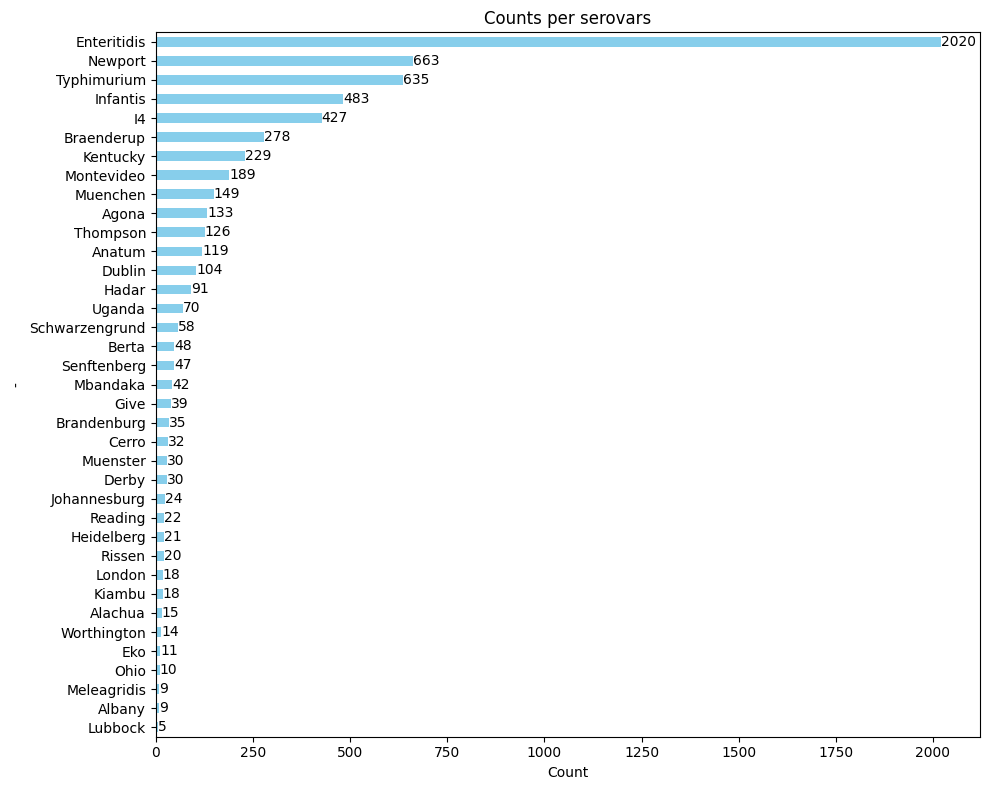

In [ ]:
import matplotlib.pyplot as plt
counts_per_strain = final_df['Computed types'].value_counts()

# Create bar plot
plt.figure(figsize=(10, 8))
ax = counts_per_strain.plot(kind='barh', color='skyblue')
plt.xlabel('Count')
plt.ylabel('-')
plt.title('Counts per serovars')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top

# Annotate each bar with its count
for i, count in enumerate(counts_per_strain):
    ax.text(count, i, str(count), ha='left', va='center', color='black')

plt.tight_layout()
plt.show()
